# 5.3 Skill Level Detection

Module - Pose Estimation

For book, references and training materials, please check this project website [http://activefitness.ai/ai-in-sports-with-python](http://activefitness.ai/ai-in-sports-with-python).

Reference: Chapter 7, [Applied Machine Learning for Health and Fitness](https://www.apress.com/us/book/9781484257715)


## Finding similarities in data

In [ ]:
!openpose.bin --model_pose COCO --video media/video.avi --write_json media/json

### Dynamic Time Warping (DTW)

In [8]:
from utils.keypoints import pose
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import medfilt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import DistanceMetric
from sklearn.metrics import classification_report
%matplotlib inline

def load_features(names):
    output = [] 
    for filename in names:
        ps = pose.PoseSequence.load('data/dtw/sample/'+filename)
        poses = ps.poses

        right_present = [1 for pose in poses 
                if pose.rshoulder.exists and pose.relbow.exists and pose.rwrist.exists]
        left_present = [1 for pose in poses
                if pose.lshoulder.exists and pose.lelbow.exists and pose.lwrist.exists]
        right_count = sum(right_present)
        left_count = sum(left_present)
        side = 'right' if right_count > left_count else 'left'

        if side == 'right':
            joints = [(pose.rshoulder, pose.relbow, pose.rwrist, pose.rhip, pose.neck) for pose in poses]
        else:
            joints = [(pose.lshoulder, pose.lelbow, pose.lwrist, pose.lhip, pose.neck) for pose in poses]

        # filter out data points where a part does not exist
        joints = [joint for joint in joints if all(part.exists for part in joint)]
        
        upper_arm_vecs = np.array([(joint[0].x - joint[1].x, joint[0].y - joint[1].y) for joint in joints])
        forearm_vecs = np.array([(joint[2].x - joint[1].x, joint[2].y - joint[1].y) for joint in joints])
        
        upper_arm_vecs = upper_arm_vecs / np.expand_dims(np.linalg.norm(upper_arm_vecs, axis=1), axis=1)
        forearm_vecs = forearm_vecs / np.expand_dims(np.linalg.norm(forearm_vecs, axis=1), axis=1)
        
        upper_arm_forearm_angle = np.degrees(np.arccos(np.clip(np.sum(np.multiply(upper_arm_vecs, forearm_vecs), axis=1), -1.0, 1.0)))
        upper_arm_forearm_angle_filtered = medfilt(medfilt(upper_arm_forearm_angle, 5), 5)

        output.append(upper_arm_forearm_angle_filtered.tolist())
    return output

   
def path_cost(x, y, accumulated_cost, distances):
    path = [[len(x)-1, len(y)-1]]
    cost = 0
    i = len(x)-1
    j = len(y)-1
    while i>0 and j>0:
        if i==0:
            j = j - 1
        elif j==0:
            i = i - 1
        else:
            if accumulated_cost[i-1, j] == min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]):
                i = i - 1
            elif accumulated_cost[i, j-1] == min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]):
                j = j-1
            else:
                i = i - 1
                j= j- 1
        path.append([i, j])
    path.append([0,0])
    for [x,y] in path:
        cost = cost +distances[x,y]
    return path, cost    


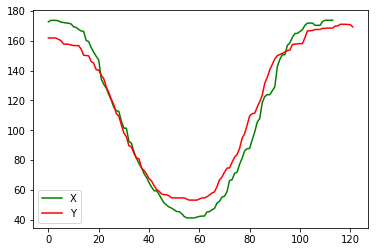

In [9]:
data = load_features(['x.npy','y.npy'])
x = data[0]
y = data[1]
plt.plot(x, 'g', label='X')
plt.plot(y, 'r', label='Y')
plt.legend();
plt.show()

In [10]:
distances = np.zeros((len(x), len(y)))
distances.shape
for i in range(len(x)):
    for j in range(len(y)):
        distances[i,j] = (x[i]-y[j])**2 
distances

array([[120.32803063, 120.32803063, 120.32803063, ...,   3.63993664,
          4.15945387,  12.25589118],
       [139.93723107, 139.93723107, 139.93723107, ...,   7.66157589,
          8.40749055,  19.01775303],
       [139.93723107, 139.93723107, 139.93723107, ...,   7.66157589,
          8.40749055,  19.01775303],
       ...,
       [142.24034099, 142.24034099, 142.24034099, ...,   8.20767431,
          8.97910823,  19.87272611],
       [142.24034099, 142.24034099, 142.24034099, ...,   8.20767431,
          8.97910823,  19.87272611],
       [142.24034099, 142.24034099, 142.24034099, ...,   8.20767431,
          8.97910823,  19.87272611]])

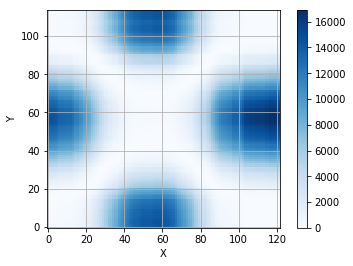

In [11]:
def distance_cost_plot(distances):
    im = plt.imshow(distances, interpolation='nearest', cmap='Blues') 
    plt.gca().invert_yaxis()
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid()
    plt.colorbar()

distance_cost_plot(distances)
plt.show()

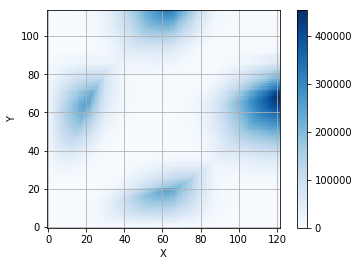

In [12]:
accumulated_cost = np.zeros((len(x), len(y)))
accumulated_cost[0,0] = distances[0,0]
for i in range(1, len(x)):
    accumulated_cost[i,0] = distances[i,0] + accumulated_cost[i-1,i] 
for i in range(1, len(x)):
    for j in range(1, len(y)):
        accumulated_cost[i, j] = min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]) + distances[i, j]
        
distance_cost_plot(accumulated_cost)

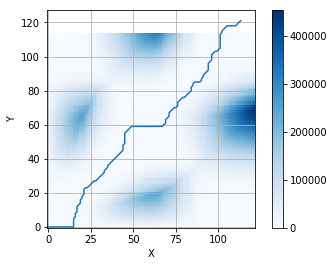

2238.139192931555


In [13]:
path = [[len(x)-1, len(y)-1]]
i = len(x)-1
j = len(y)-1
while i>0 and j>0:
    if i==0:
        j = j - 1
    elif j==0:
        i = i - 1
    else:
        if accumulated_cost[i-1, j] == min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]):
            i = i - 1
        elif accumulated_cost[i, j-1] == min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]):
            j = j-1
        else:
            i = i - 1
            j= j- 1
    path.append([i, j])
path.append([0,0])

path_x = [point[0] for point in path]
path_y = [point[1] for point in path]

distance_cost_plot(accumulated_cost)
plt.plot(path_x, path_y)
plt.show()

path, cost = path_cost(x, y, accumulated_cost, distances)
print(cost)

488.70072893464635


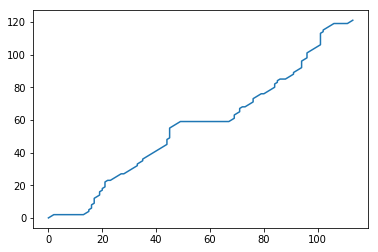

In [14]:
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
distance, path = fastdtw(x, y, dist=euclidean)
print(distance)

path_x = [point[0] for point in path]
path_y = [point[1] for point in path]
plt.plot(path_x, path_y)
plt.show()

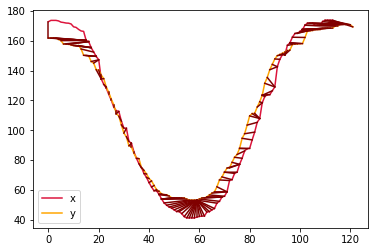

In [15]:
plt.plot(x, 'crimson' ,label='x')
plt.plot(y, 'orange',label = 'y')
plt.legend();
paths = path_cost(x, y, accumulated_cost, distances)[0]
for [map_x, map_y] in paths:
    plt.plot([map_x, map_y], [x[map_x], y[map_y]], 'maroon')
plt.show()

## Detecting skill level


In [16]:
import numpy as np
import math
import glob
import utils

from utils.keypoints import pose, utils
from pprint import pprint
from scipy.signal import medfilt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import DistanceMetric
from sklearn.metrics import classification_report

files = utils.files_in_order('data/dtw/skiing/experiments')
#print(files)
X_train_names, X_test_names = train_test_split(files, test_size=0.4, random_state=42)
y_train = utils.get_labels_by_level(X_train_names)
y_test = utils.get_labels_by_level(X_test_names)
pprint(X_train_names)
pprint(y_train)
pprint(X_test_names)
pprint(y_test)

array(['skicarve_expert_1.npy', 'skikidwedge_beginner_1.npy'],
      dtype='<U26')
array([1, 0])
array(['skicarve_expert_2.npy', 'skikidwedge_beginner_2.npy'],
      dtype='<U26')
array([1, 0])


Max torso/neck angle:  82.75143413220597


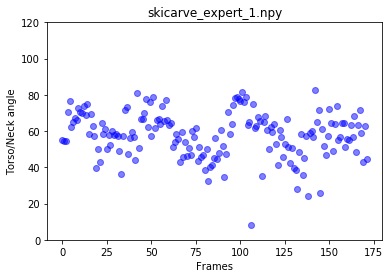

Max torso/neck angle:  112.85492870025797


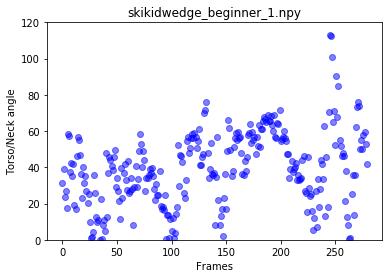

Max torso/neck angle:  82.75143413220597


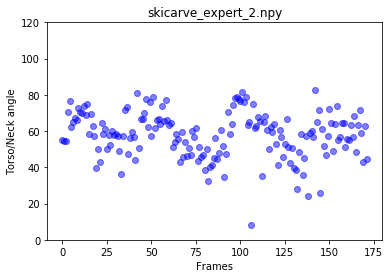

Max torso/neck angle:  112.85492870025797


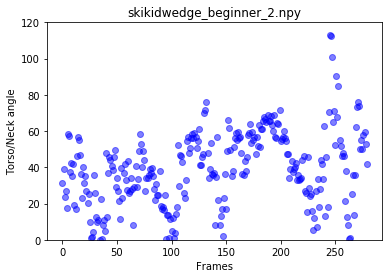

In [17]:
def load_features(names):
    output1 = [] # List of upper arm torso angles
    output2 = [] # List of forearm upper arm angles
    for filename in names:
        ps = pose.PoseSequence.load('data/dtw/skiing/experiments/'+filename)
        poses = ps.poses

        dominant_side = utils.get_side(poses)
    
        if dominant_side == 'right':
            joints = utils.get_joints([(pose.nose, pose.neck, pose.rhip) for pose in poses])
        else:
            joints = utils.get_joints([(pose.nose, pose.neck, pose.lhip) for pose in poses])

        # looking down at skis
        neck = utils.get_normalized_joint_vector(joints, 0, 1)
        torso = utils.get_normalized_joint_vector(joints, 1, 2)
        angles = utils.get_angle(torso, neck)
        angles_filtered = medfilt(medfilt(angles, 5), 5)
        print("Max torso/neck angle: ", np.max(angles))
        utils.chart(angles, filename, 'Torso/Neck angle', 'blue')

        joints = utils.get_joints([(pose.rhip, pose.lhip, pose.rknee, pose.lknee, pose.rankle, pose.lankle) for pose in poses])

        rhip = utils.get_normalized_joint_vector(joints, 0, 2)
        lhip = utils.get_normalized_joint_vector(joints, 1, 3)
        rankle = utils.get_normalized_joint_vector(joints, 2, 4)
        lankle = utils.get_normalized_joint_vector(joints, 3, 5)

        # calculate angles
        rknee_angle = utils.get_angle(rhip, rankle)
        lknee_angle = utils.get_angle(lhip, lankle)
        
        rknee_angle_filtered = medfilt(medfilt(rknee_angle, 5), 5)
        lknee_angle_filtered = medfilt(medfilt(lknee_angle, 5), 5)
        
        output1.append(angles_filtered.tolist())
        output2.append(lknee_angle_filtered.tolist())
    return output1, output2

X_train_1, X_train_2 = load_features(X_train_names)
X_test_1, X_test_2 = load_features(X_test_names)